In [20]:
import os
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import geopandas as gp
import sklearn.preprocessing

In [21]:
# Read in the CSVs from the data folder

# find files
data_dir = "../data"
files = [os.path.join(data_dir,x) for x in os.listdir("../data")]

# read as dataframes
p = pd.read_csv(files[0])
q = pd.read_csv(files[1])
et = pd.read_csv(files[2])
ds = pd.read_csv(files[3], sep='\t', header=0)

# set indices as time
p.set_index(p.columns[0], inplace=True)
q.set_index(q.columns[0], inplace = True)
et.set_index(et.columns[0], inplace = True)
ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)
p.index = pd.to_datetime(p.index)
q.index = pd.to_datetime(q.index)
et.index = pd.to_datetime(et.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)

# Merge the dfs
p_q = pd.merge(p,q, left_index=True, right_index=True)
p_q_et = pd.merge(p_q, et, left_index=True, right_index=True)

# Set the timezones to none
p_q_et = p_q_et.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(p_q_et, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [36]:
# Get the area over which precip and ET were calculated over
hu4 = gp.read_file("../shape/cv_hu6.shp")
study_area = hu4.AreaSqKm.values
study_area = study_area * 1000000. # sq km to sq m

# Now convert to the appropriate units

df['q'] = df.discharge_cms*2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_gridmet'] = df.gridmet*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_modis'] = df.modis*study_area * 1e-3 # multiply by study area and convert mm to m
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [37]:
df['ds_mod'] = df.p - df.et_modis - df.q
df['ds_gridmet'] = df.p - df.et_gridmet - df.q

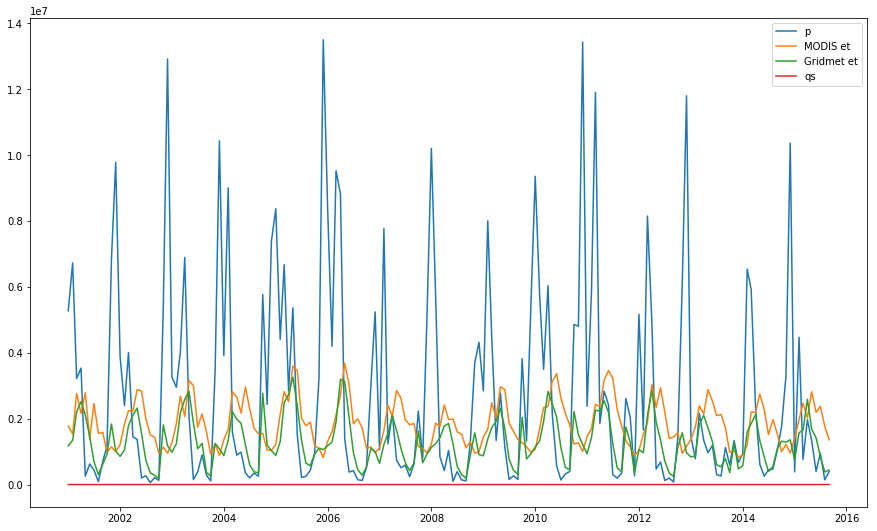

In [38]:
plt.figure(figsize = (15, 9))

plt.plot(df.index,df['prism'], label = "p")
plt.plot(df.index,df['modis'], label = "MODIS et")
plt.plot(df.index,df['gridmet'], label = "Gridmet et")
plt.plot(df.index,df['discharge_cms'], label = "qs")

plt.legend()
plt.show()

In [43]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year+1)

sums_gm = {}

for year in years:
    ds = df[df.index.year == year]
    ds_year = np.sum(ds['ds_gridmet'])
    sums_gm[year] = ds_year
    
sums_mod = {}

for year in years:
    ds = df[df.index.year == year]
    ds_year = np.sum(ds['ds_mod'])
    sums_mod[year] = ds_year

In [50]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame(sums_mod.values(), index = dt_idx)
ds_df.columns = ["ds_modis"]
ds_df['ds_gridmet'] = sums_gm.values()

ds_df.head()

,ds_modis,ds_gridmet
2001-12-31,7.431927e+14,9.520963e+14
2002-12-31,4.691887e+14,7.666406e+14
2003-12-31,5.270515e+14,7.630072e+14
2004-12-31,4.378960e+14,7.359269e+14
2005-12-31,9.853172e+14,1.232541e+15


In [51]:
window = 3
ds_df['s_m'] = ds_df['ds_modis'].rolling(window, win_type='triang').mean()
ds_df['s_gm'] = ds_df['ds_gridmet'].rolling(window, win_type='triang').mean()

In [57]:
mms = sklearn.preprocessing.MinMaxScaler()

scaled = []

for i in [ds_df['ds_modis'],ds_df['ds_gridmet'],ds_df['s_m'],ds_df['s_gm'],df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


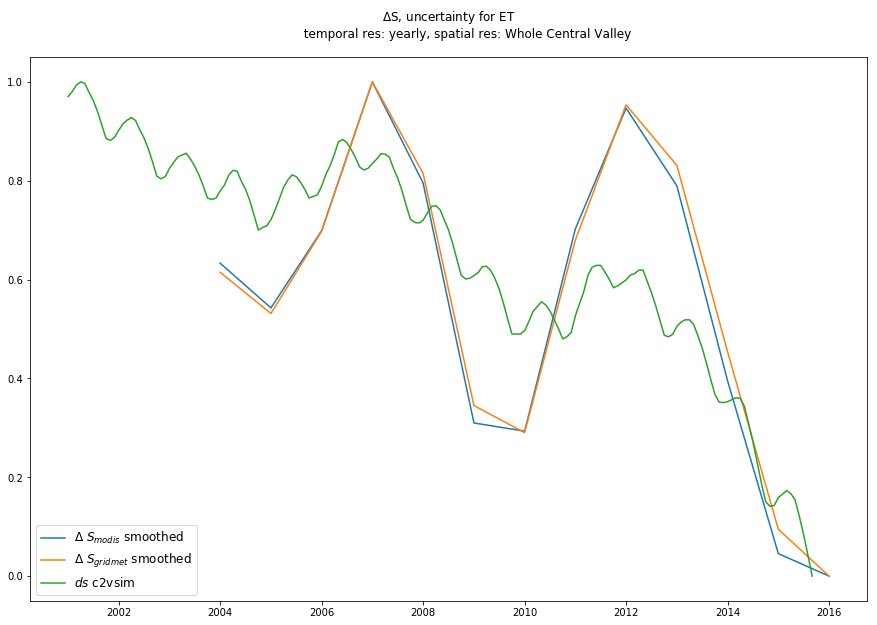

In [78]:
plt.figure(figsize=(15,10))

plt.title("""$\Delta$S, uncertainty for ET 
          temporal res: yearly, spatial res: Whole Central Valley
          """)
# plt.plot(ds_df.index, scaled[0], label = "$\d{smod} = P - ET_{mod} - Q_s$")
plt.plot(ds_df.index[window-1:], scaled[2], label = '$\Delta$ $S_{modis}$ smoothed')

# plt.plot(ds_df.index, scaled[1], label = "$\Delta$ $S_{gm} = P - ET_{gridmet} - Q_s$")
plt.plot(ds_df.index[window-1:], scaled[3], label = '$\Delta$ $S_{gridmet}$ smoothed')

plt.plot(df.index, scaled[4], label = "$ds$ c2vsim")

plt.legend(loc="lower left", fontsize = 'large')

plt.show()